---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

## Importing Libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter, defaultdict
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Setting Seed

In [18]:
SEED = 2
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Setting Constants and Device

In [19]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
TRANSFORMER_HEADS = 4
TRANSFORMER_LAYERS = 2
DROPOUT_RATE = 0.3

In [20]:
#GPU or CPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [21]:
def load_data(file_path):
    """
    Function to read through input file and rerun senteces and assocated tags

    Args:
    file_path (str) -> path of the txt file

    Returns:
    sentences (list) -> list of sentences
    tags (list) -> list of tags
    """
    sentences = []
    tags = []
    current_sentence = []
    current_tags = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                word, tag = line.split()
                current_sentence.append(word)
                current_tags.append(tag)
            else:  # End of sentence
                if current_sentence:  # If sentence is not empty
                    sentences.append(current_sentence)
                    tags.append(current_tags)
                    current_sentence = []
                    current_tags = []

        # Add the last sentence if file doesn't end with an empty line
        if current_sentence:
            sentences.append(current_sentence)
            tags.append(current_tags)


    num_sentences = len(sentences)
    total_tokens = sum(len(s) for s in sentences)
    tag_counter = Counter()
    for sentence_tags in tags:
        tag_counter.update(sentence_tags)

    # Print stats
    print(f"Dataset Statistics:")
    print(f"Number of sentences: {num_sentences}")
    print(f"Number of unique tags: {len(tag_counter)}")

    print("\nTag distribution:")
    for tag, count in tag_counter.most_common():
        print(f"{tag}: {count} ({count/total_tokens*100:.2f}%)")

    return sentences, tags



In [22]:
def word_tag_counter(sentences, tags):
    """
    Function to count words and tags

    Args:
    sentences (list) -> list of sentences
    tags (list) -> list of tags

    Returns:
    word_to_idx (dict) -> dictionary of words
    tag_to_idx (dict) -> dictionary of tags with tags as keys
    idx_to_tag (dict) -> dictionary of tags with indexes as keys
    """
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update(sentence)

    tag_set = set()
    for sentence_tags in tags:
        tag_set.update(sentence_tags)

    # Create mappings
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    for word in word_counts:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)

    tag_to_idx = {"<PAD>": 0}
    for tag in sorted(tag_set):  # Sort to ensure consistent ordering
        tag_to_idx[tag] = len(tag_to_idx)

    idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

    print(f"Vocabulary size: {len(word_to_idx)}")
    print(f"Tag classes: {len(tag_to_idx) - 1 }")
    print(f"Tags: {sorted(tag_set)}")

    return word_to_idx, tag_to_idx, idx_to_tag

## Importing Data and Splitting data into Training and Test Data

In [23]:
data_path = '/content/assignment3-ner_dataset.txt'
sentences, tags = load_data(data_path)

train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=SEED)

word_index, tag_index, index_tag = word_tag_counter(train_sentences, train_tags)

Dataset Statistics:
Number of sentences: 1696
Number of unique tags: 5

Tag distribution:
O: 32576 (83.51%)
I-ORG: 1958 (5.02%)
I-PER: 1634 (4.19%)
I-LOC: 1447 (3.71%)
I-MISC: 1392 (3.57%)
Vocabulary size: 7459
Tag classes: 5
Tags: ['I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [24]:
def collate_fn(batch):
    """
    Custom Collate Function

    Args:
    batch (list) -> list of batches

    Returns:
    words (torch.Tensor) -> tensor of words
    tags (torch.Tensor) -> tensor of tags
    lengths (torch.Tensor) -> tensor of lengths
    """
    batch = sorted(batch, key=lambda x: x['length'], reverse=True)
    words = [item['words'] for item in batch]
    tags = [item['tags'] for item in batch]
    lengths = [item['length'] for item in batch]

    words_padded = pad_sequence(words, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)

    return {
        'words': words_padded,
        'tags': tags_padded,
        'lengths': torch.tensor(lengths, dtype=torch.long)
    }


In [25]:
class NERDataset(Dataset):
    """
    NER Dataset Class

    Args:
    sentences (list) -> list of sentences
    tags (list) -> list of tags
    word_to_idx (dict) -> dictionary of words
    tag_to_idx (dict) -> dictionary of tags
    """
    def __init__(self, sentences, tags, word_to_idx, tag_to_idx):
        self.sentences = sentences
        self.tags = tags
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]

        # Convert words and tags to indices
        word_indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in words]
        tag_indices = [self.tag_to_idx.get(tag, 0) for tag in tags]

        return {
            'words': torch.tensor(word_indices, dtype=torch.long),
            'tags': torch.tensor(tag_indices, dtype=torch.long),
            'length': len(words)
        }

def data_loader(sentences,tags, word_index,tag_index,index_tag,fold_indices = None):
  """
  Function to return a Dataloader object to input into NN

  Args:
  sentences (list) -> list of sentences
  tags (list) -> list of tags
  word_index (dict) -> dictionary of words
  tag_index (dict) -> dictionary of tags
  index_tag (dict) -> dictionary of tags with index as keys
  fold_indices (dict) -> dictionary with the type of fold(validation or Training)
                        Default as None\
  Returns:
  train_loader (DataLoader Object) -> DataLoader object for training data
  val_loader (DataLoader Object) -> DataLoader object for validation data

  """
  if fold_indices == None:
    dataset = NERDataset(sentences, tags, word_index, tag_index)
    return DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

  else:
    trainSentences = [sentences[i] for i in fold_indices['train']]
    trainTags = [tags[i] for i in fold_indices['train']]
    valSentences = [sentences[i] for i in fold_indices['val']]
    valTags = [tags[i] for i in fold_indices['val']]

    train_dataset = NERDataset(trainSentences, trainTags, word_index, tag_index)
    val_dataset = NERDataset(valSentences, valTags, word_index, tag_index)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader

---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

In [26]:
# LSTM
class LSTM(nn.Module):
  """
  Custom LSTM class importing from NN module
  Args:
  vocab_size (int) -> size of the vocabulary
  tag_size (int) -> size of the tags
  embedding_dim (int) -> size of the embedding
  hidden_dim (int) -> size of the hidden layer
  num_layers (int) -> number of layers
  bidirectional (bool) -> whether to use bidirectional LSTM
  dropout (float) -> dropout rate
  """
  def __init__(self, vocab_size, tag_size,embedding_dim, hidden_dim, num_layers = 1,bidirectional=True, dropout= 0.3 ):
    super(LSTM, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.dropout = dropout
    self.vocab_size = vocab_size
    self.tag_size = tag_size

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim,
                         hidden_dim // 2 if bidirectional else hidden_dim,
                         num_layers=num_layers,
                         bidirectional=bidirectional,
                         dropout=dropout if num_layers > 1 else 0,
                         batch_first=True)

    self.dropout = nn.Dropout(dropout)
    self.hidden2tag = nn.Linear(hidden_dim, tag_size)

  def forward(self, sentence, lengths):
    embeds = self.word_embeddings(sentence)
    packed_embeds = pack_padded_sequence(embeds, lengths.cpu(), batch_first=True)

    lstm_out, _ = self.lstm(packed_embeds)
    lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)

    lstm_out = self.dropout(lstm_out)
    tag_space = self.hidden2tag(lstm_out)

    return tag_space



In [27]:
#Transformer and Encoder

class PositionalEncoding(nn.Module):
  """
  Custom Postional Encoder class importing from NN module for encoding in Transformer
  Args:
  d_model (int) -> size of the embedding
  max_len (int) -> maximum length of the sequence
  """

  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    posenc = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

    posenc[:, 0::2] = torch.sin(position * div_term)
    posenc[:, 1::2] = torch.cos(position * div_term)
    posenc = posenc.unsqueeze(0)

    self.register_buffer('posenc', posenc)

  def forward(self, x):
        return x + self.posenc[:, :x.size(1), :]



class Transformer(nn.Module):
  """
  Custom Transformer class importing from NN module
  Args:
  vocab_size (int) -> size of the vocabulary
  tag_size (int) -> size of the tags
  embedding_dim (int) -> size of the embedding
  hidden_dim (int) -> size of the hidden layer
  nhead (int) -> number of heads in the multi-head attention
  num_layers (int) -> number of layers
  dropout (float) -> dropout rate
  """
  def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim,
               nhead=TRANSFORMER_HEADS, num_layers=TRANSFORMER_LAYERS, dropout=DROPOUT_RATE):
    super(Transformer, self).__init__()

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.pos_encoder = PositionalEncoding(embedding_dim)
    self.input_projection = nn.Linear(embedding_dim, hidden_dim)

    encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead,
                                               dim_feedforward=hidden_dim*4,
                                               batch_first=True,
                                               dropout=dropout)


    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.dropout = nn.Dropout(dropout)
    self.hidden2tag = nn.Linear(hidden_dim, tag_size)

  def forward(self, sentence, lengths):
    mask = self._create_mask(sentence, lengths)
    embeds = self.word_embeddings(sentence)  # [batch_size, seq_len, embedding_dim]

    embeds = self.pos_encoder(embeds)
    embeds = self.input_projection(embeds)

    transformer_out = self.transformer_encoder(embeds, src_key_padding_mask=mask)
    transformer_out = self.dropout(transformer_out)

    tag_space = self.hidden2tag(transformer_out)  # [batch_size, seq_len, tagset_size]

    return tag_space

  def _create_mask(self, x, lengths):
    batch_size, max_len = x.size()
    mask = torch.arange(max_len).expand(batch_size, max_len) >= lengths.unsqueeze(1)
    return mask.to(x.device)

In [28]:
#Function to train 1 Epoch
def train_epoch(model, train_loader, optimizer, criterion, device):
  """
  Function to train the NN model for 1 epoch
  Args:
  model (Custom Class) -> either LSTM or Transformer
  train_loader (DataLoader Object) -> DataLoader object for training data
  optimizer -> optim.Adam object
  criterion -> nn.CrossEntropyLoss object
  device -> torch.device object


  Returns:
  epochloss/totalSamples (float) -> loss for the epoch
  epochacc/totalSamples (float) -> accuracy for the epoch
  """
  model.train()

  epochloss = 0
  epochacc = 0
  totalSamples = 0
  for batch in train_loader:
    words = batch['words'].to(device)
    tags = batch['tags'].to(device)
    lengths = batch['lengths']
    optimizer.zero_grad()

    tag_scores = model(words, lengths)
    batch_size, seq_len, num_tags = tag_scores.size()
    tag_scores = tag_scores.view(-1, num_tags)
    tags = tags.view(-1)

    mask = tags != 0
    loss = criterion(tag_scores, tags)
    masked_loss = loss * mask.float()
    masked_loss = masked_loss.sum() / mask.sum().float()
    masked_loss.backward()
    optimizer.step()

    _, predicted_tags = torch.max(tag_scores, 1)
    correct = ((predicted_tags == tags) * mask).sum().item()
    total = mask.sum().item()

    epochloss += masked_loss.item() * total
    epochacc += correct
    totalSamples += total

  return epochloss / totalSamples, epochacc / totalSamples

In [29]:
def evaluate(model,data_loader,criterion,device,index_tag = None):
  """
  Function to evaluate the NN model
  Args:
  model (Custom Class) -> either LSTM or Transformer
  data_loader (DataLoader Object) -> DataLoader object for training data
  criterion -> nn.CrossEntropyLoss object

  Returns:
  metrics (dict) -> dictionary of metrics
  """
  model.eval()
  epoch_loss = 0; epoch_accuracy = 0
  total_samples = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in data_loader:
      words = batch['words'].to(device)
      tags = batch['tags'].to(device)
      lengths = batch['lengths']

      tag_scores = model(words, lengths)

      batch_size, seq_len, num_tags = tag_scores.size()
      tag_scores = tag_scores.view(-1, num_tags)
      tags = tags.view(-1)

      mask = tags != 0
      loss = criterion(tag_scores, tags)
      masked_loss = loss * mask.float()
      masked_loss = masked_loss.sum() / mask.sum().float()

      _, predicted_tags = torch.max(tag_scores, 1)
      correct = ((predicted_tags == tags) * mask).sum().item()
      total = mask.sum().item()

      epoch_loss += masked_loss.item() * total
      epoch_accuracy += correct
      total_samples += total

      if index_tag is not None:
        for i in range(batch_size):
          length = lengths[i].item()
          pred_seq = predicted_tags.view(batch_size, seq_len)[i, :length].cpu().numpy()
          actual_seq = tags.view(batch_size, seq_len)[i, :length].cpu().numpy()

          pred_seq = [index_tag[p] for p in pred_seq if p != 0]
          actual_seq = [index_tag[a] for a in actual_seq if a != 0]

          all_preds.extend(pred_seq)
          all_labels.extend(actual_seq)

    metrics = {
        'loss': epoch_loss / total_samples,
        'accuracy': epoch_accuracy / total_samples
    }

    if index_tag is not None and len(all_preds) > 0:
      filtered_labels = [label for label in all_labels if label != '<PAD>']
      filtered_predictions = [pred for pred, label in zip(all_preds, all_labels) if label != '<PAD>']
      unique_tags = sorted(set(filtered_labels))

      metrics['f1'] = f1_score(filtered_labels, filtered_predictions, average='macro',labels = unique_tags)
      metrics['precision'] = precision_score(filtered_labels, filtered_predictions, average='macro', labels = unique_tags)
      metrics['recall'] = recall_score(filtered_labels, filtered_predictions, average='macro',labels = unique_tags)
      report = classification_report(filtered_labels, filtered_predictions, target_names=index_tag.values(),labels = unique_tags)
      metrics['report'] = report
      metrics['filtered_labels'] = filtered_labels
      metrics['filtered_predictions'] = filtered_predictions
      metrics['unique_tags'] = unique_tags

    return metrics


In [30]:
def train_model(model_type, sentences, tags, word_index, tag_index, index_tag):
  """
  Function to Train the NN model over 20 Epochs
  Based on model_type, either LSTM or Transformer is called and trained

  Args:
  model_type (str) -> either LSTM or Transformer
  sentences (list) -> list of sentences
  tags (list) -> list of tags
  word_index (dict) -> dictionary of words
  tag_index (dict) -> dictionary of tags
  index_tag (dict) -> dictionary of tags with index as keys

  Returns:
  final_model (Custom Class) -> either LSTM or Transformer
  finalMetrics (dict) -> dictionary of metrics
  """
  epochs = 20
  vocab_size = len(word_index)
  tag_size = len(tag_index)

  kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

  trainlosses_all =[]
  trainaccs_all = []
  vallosses_all = []
  valaccs_all = []

  bestf1 =0; best_fold = 0
  bestmodel = None

  for fold, (train_idx, val_idx) in enumerate(kf.split(sentences)):
    print(f"Fold {fold+1}/5")
    fold_indices = {
            'train': train_idx,
            'val': val_idx}
    train_loader, val_loader = data_loader(sentences,tags,word_index,tag_index,index_tag,fold_indices)

    if model_type == 'LSTM':
      model = LSTM(vocab_size, tag_size, EMBEDDING_DIM, HIDDEN_DIM,
                num_layers=2, bidirectional=True, dropout=DROPOUT_RATE
            )
      model_name = 'LSTM'
    else:
      model = Transformer(vocab_size, tag_size, EMBEDDING_DIM, HIDDEN_DIM,
                nhead=TRANSFORMER_HEADS, num_layers=TRANSFORMER_LAYERS, dropout=DROPOUT_RATE
            )
      model_name = 'Transformer'

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trainlosses_fold = []
    trainaccs_fold = []
    vallosses_fold = []
    valaccs_fold = []
    print(f"Training {model_name}")
    for epoch in range(epochs):
      trainloss, trainacc = train_epoch(model, train_loader, optimizer, criterion, device)
      valMetrics = evaluate(model, val_loader, criterion, device,index_tag)
      valloss = valMetrics['loss']
      valacc = valMetrics['accuracy']

      trainlosses_fold.append(trainloss)
      trainaccs_fold.append(trainacc)
      vallosses_fold.append(valloss)
      valaccs_fold.append(valacc)

      print(f"Epoch {epoch+1}/{epochs}, Train Loss: {trainloss:.4f}, Train Acc: {trainacc:.4f}, Val Loss: {valloss:.4f}, Val Acc: {valacc:.4f}")

      if 'f1' in valMetrics:
        #print(f"Val F1: {valMetrics['f1']:.4f}")
        if valMetrics['f1'] > bestf1:
          bestf1 = valMetrics['f1']
          best_fold = fold
          bestmodel = model.state_dict().copy()


    plot_training_curves(
            trainlosses_fold, vallosses_fold,
            trainaccs_fold, valaccs_fold,
            title=f"{model_name} - Fold {fold+1} Training Curves",
            model_name = str(model_name) + str(fold + 1) )

  trainlosses_all.append(trainlosses_fold)
  trainaccs_all.append(trainaccs_fold)
  vallosses_all.append(vallosses_fold)
  valaccs_all.append(valaccs_fold)
  print("End of training")

  trainlosses_avg = np.mean(np.array(trainlosses_all), axis=0)
  trainaccs_avg = np.mean(np.array(trainaccs_all), axis=0)
  vallosses_avg = np.mean(np.array(vallosses_all), axis=0)
  valaccs_avg = np.mean(np.array(valaccs_all), axis=0)

  plot_training_curves(
            trainlosses_avg, vallosses_avg,
            trainaccs_avg, valaccs_avg,
            title=f"{model_name} - Average Training Curves",
            model_name = str(model_name) + "_avg")

  print(f"\nBest model from fold {best_fold+1} with F1 score: {bestf1:.4f}")

  if model_name == 'LSTM':
    final_model = LSTM(vocab_size, tag_size, EMBEDDING_DIM, HIDDEN_DIM,
                num_layers=2, bidirectional=True, dropout=DROPOUT_RATE
            )
  else:
    final_model = Transformer(vocab_size, tag_size, EMBEDDING_DIM, HIDDEN_DIM,
                nhead=TRANSFORMER_HEADS, num_layers=TRANSFORMER_LAYERS, dropout=DROPOUT_RATE
            )
  final_model.load_state_dict(bestmodel)
  final_model.to(device)

  finalMetrics={
      "train_loss": trainlosses_avg[-1],
      "train_acc": trainaccs_avg[-1],
      "val_loss": vallosses_avg[-1],
      "val_acc": valaccs_avg[-1],
      "bestF1": bestf1
  }

  return final_model,finalMetrics



In [31]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, title="Training Curves", model_name = "Model"):
    """
    Function to Plot training and validation curves
    Args:
    train_losses (list) -> list of training losses
    val_losses (list) -> list of validation losses
    train_accs (list) -> list of training accuracies
    val_accs (list) -> list of validation accuracies
    title (str) -> title of the plot
    model_name (str) -> name of the model

    Returns:
    None
    """
    filename = f"{model_name}_training_curves.png"
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()


## Creating and training LSTM

Fold 1/5
Training LSTM
Epoch 1/20, Train Loss: 1.0702, Train Acc: 0.7977, Val Loss: 0.6465, Val Acc: 0.8516
Epoch 2/20, Train Loss: 0.6863, Train Acc: 0.8296, Val Loss: 0.6047, Val Acc: 0.8516
Epoch 3/20, Train Loss: 0.6295, Train Acc: 0.8296, Val Loss: 0.5544, Val Acc: 0.8516
Epoch 4/20, Train Loss: 0.5587, Train Acc: 0.8299, Val Loss: 0.5092, Val Acc: 0.8516
Epoch 5/20, Train Loss: 0.4895, Train Acc: 0.8392, Val Loss: 0.4784, Val Acc: 0.8582
Epoch 6/20, Train Loss: 0.4219, Train Acc: 0.8585, Val Loss: 0.4518, Val Acc: 0.8644
Epoch 7/20, Train Loss: 0.3596, Train Acc: 0.8812, Val Loss: 0.4394, Val Acc: 0.8664
Epoch 8/20, Train Loss: 0.2962, Train Acc: 0.9022, Val Loss: 0.4255, Val Acc: 0.8736
Epoch 9/20, Train Loss: 0.2392, Train Acc: 0.9234, Val Loss: 0.4323, Val Acc: 0.8714
Epoch 10/20, Train Loss: 0.1873, Train Acc: 0.9406, Val Loss: 0.4443, Val Acc: 0.8697
Epoch 11/20, Train Loss: 0.1460, Train Acc: 0.9551, Val Loss: 0.4621, Val Acc: 0.8774
Epoch 12/20, Train Loss: 0.1160, Train A

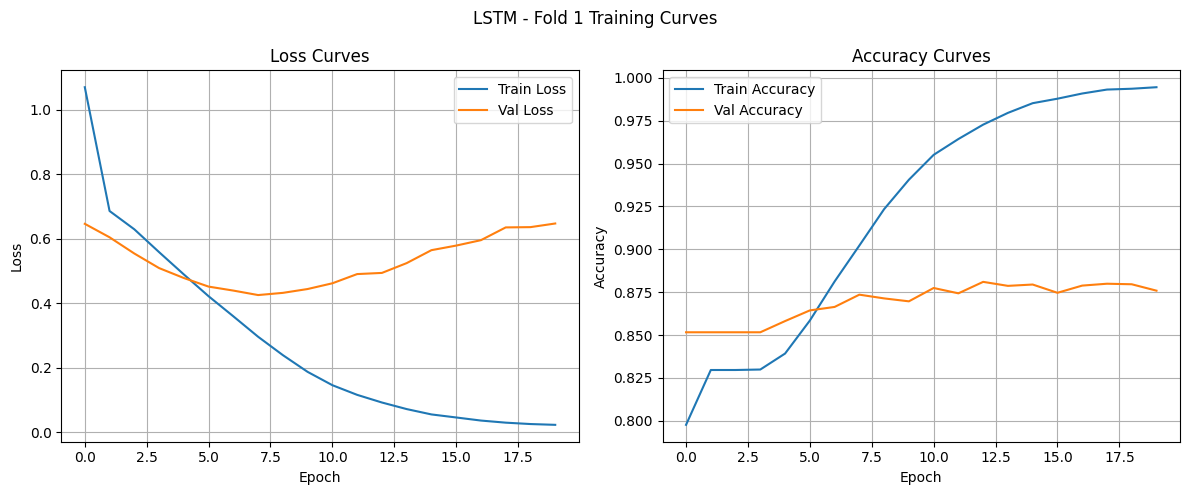

Fold 2/5
Training LSTM
Epoch 1/20, Train Loss: 1.0298, Train Acc: 0.8027, Val Loss: 0.6780, Val Acc: 0.8356
Epoch 2/20, Train Loss: 0.6694, Train Acc: 0.8338, Val Loss: 0.6313, Val Acc: 0.8356
Epoch 3/20, Train Loss: 0.6098, Train Acc: 0.8338, Val Loss: 0.5768, Val Acc: 0.8356
Epoch 4/20, Train Loss: 0.5398, Train Acc: 0.8353, Val Loss: 0.5280, Val Acc: 0.8383
Epoch 5/20, Train Loss: 0.4756, Train Acc: 0.8452, Val Loss: 0.4956, Val Acc: 0.8446
Epoch 6/20, Train Loss: 0.4122, Train Acc: 0.8621, Val Loss: 0.4707, Val Acc: 0.8467
Epoch 7/20, Train Loss: 0.3509, Train Acc: 0.8813, Val Loss: 0.4551, Val Acc: 0.8571
Epoch 8/20, Train Loss: 0.2924, Train Acc: 0.9010, Val Loss: 0.4395, Val Acc: 0.8643
Epoch 9/20, Train Loss: 0.2377, Train Acc: 0.9210, Val Loss: 0.4267, Val Acc: 0.8696
Epoch 10/20, Train Loss: 0.1895, Train Acc: 0.9370, Val Loss: 0.4407, Val Acc: 0.8778
Epoch 11/20, Train Loss: 0.1475, Train Acc: 0.9524, Val Loss: 0.4556, Val Acc: 0.8775
Epoch 12/20, Train Loss: 0.1169, Train A

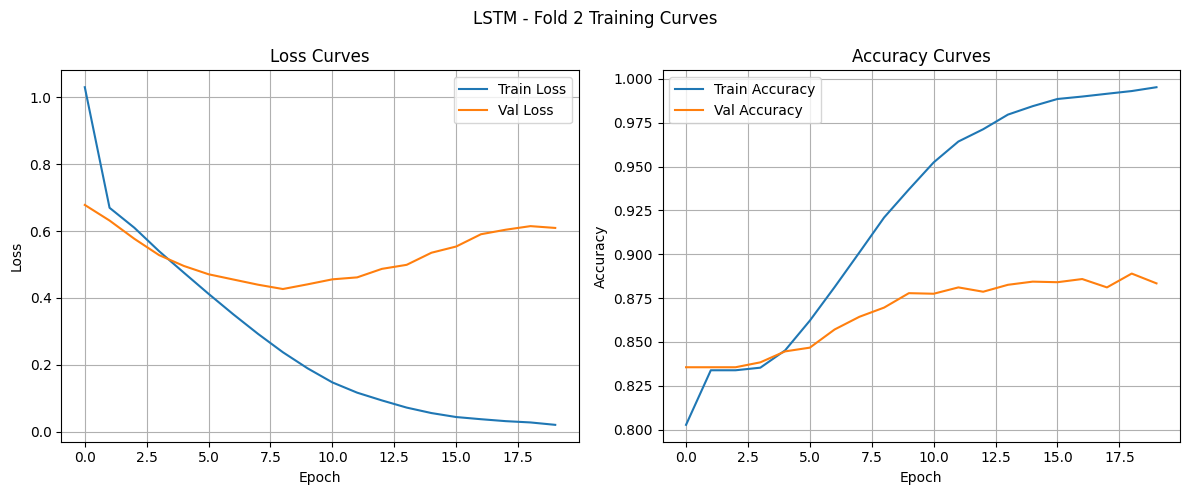

Fold 3/5
Training LSTM
Epoch 1/20, Train Loss: 1.1031, Train Acc: 0.7553, Val Loss: 0.7014, Val Acc: 0.8303
Epoch 2/20, Train Loss: 0.6770, Train Acc: 0.8351, Val Loss: 0.6703, Val Acc: 0.8303
Epoch 3/20, Train Loss: 0.6291, Train Acc: 0.8351, Val Loss: 0.6163, Val Acc: 0.8300
Epoch 4/20, Train Loss: 0.5606, Train Acc: 0.8353, Val Loss: 0.5644, Val Acc: 0.8312
Epoch 5/20, Train Loss: 0.4915, Train Acc: 0.8410, Val Loss: 0.5364, Val Acc: 0.8340
Epoch 6/20, Train Loss: 0.4278, Train Acc: 0.8555, Val Loss: 0.5047, Val Acc: 0.8345
Epoch 7/20, Train Loss: 0.3651, Train Acc: 0.8766, Val Loss: 0.4923, Val Acc: 0.8441
Epoch 8/20, Train Loss: 0.3117, Train Acc: 0.8947, Val Loss: 0.4711, Val Acc: 0.8540
Epoch 9/20, Train Loss: 0.2539, Train Acc: 0.9166, Val Loss: 0.4733, Val Acc: 0.8600
Epoch 10/20, Train Loss: 0.2035, Train Acc: 0.9356, Val Loss: 0.4714, Val Acc: 0.8603
Epoch 11/20, Train Loss: 0.1629, Train Acc: 0.9493, Val Loss: 0.4782, Val Acc: 0.8623
Epoch 12/20, Train Loss: 0.1299, Train A

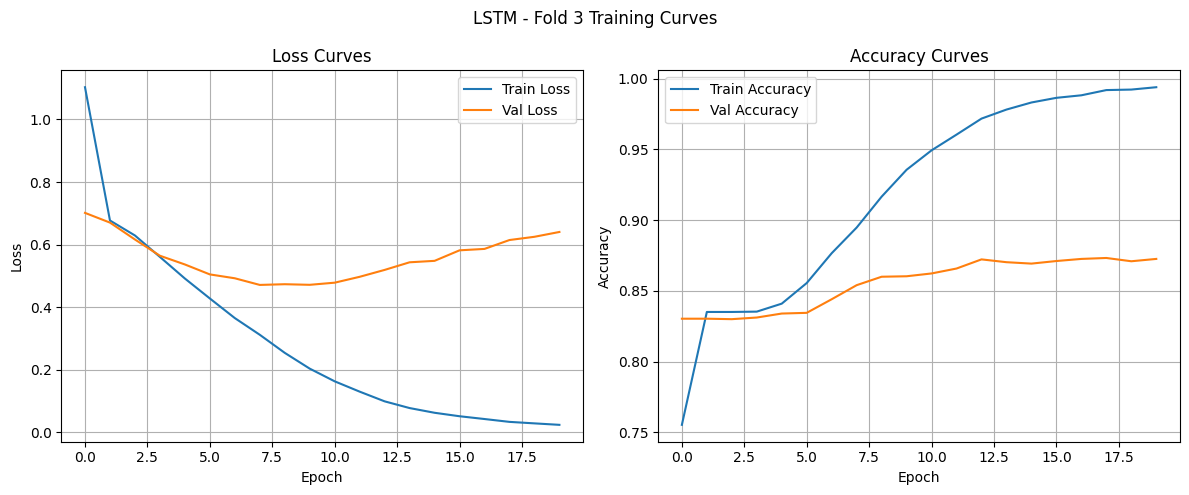

Fold 4/5
Training LSTM
Epoch 1/20, Train Loss: 1.1051, Train Acc: 0.7355, Val Loss: 0.7314, Val Acc: 0.8252
Epoch 2/20, Train Loss: 0.6749, Train Acc: 0.8364, Val Loss: 0.6869, Val Acc: 0.8252
Epoch 3/20, Train Loss: 0.6302, Train Acc: 0.8364, Val Loss: 0.6314, Val Acc: 0.8252
Epoch 4/20, Train Loss: 0.5683, Train Acc: 0.8364, Val Loss: 0.5705, Val Acc: 0.8252
Epoch 5/20, Train Loss: 0.5009, Train Acc: 0.8410, Val Loss: 0.5295, Val Acc: 0.8318
Epoch 6/20, Train Loss: 0.4378, Train Acc: 0.8552, Val Loss: 0.4951, Val Acc: 0.8445
Epoch 7/20, Train Loss: 0.3779, Train Acc: 0.8735, Val Loss: 0.4608, Val Acc: 0.8468
Epoch 8/20, Train Loss: 0.3240, Train Acc: 0.8914, Val Loss: 0.4439, Val Acc: 0.8590
Epoch 9/20, Train Loss: 0.2640, Train Acc: 0.9132, Val Loss: 0.4447, Val Acc: 0.8630
Epoch 10/20, Train Loss: 0.2141, Train Acc: 0.9305, Val Loss: 0.4392, Val Acc: 0.8712
Epoch 11/20, Train Loss: 0.1668, Train Acc: 0.9472, Val Loss: 0.4394, Val Acc: 0.8657
Epoch 12/20, Train Loss: 0.1278, Train A

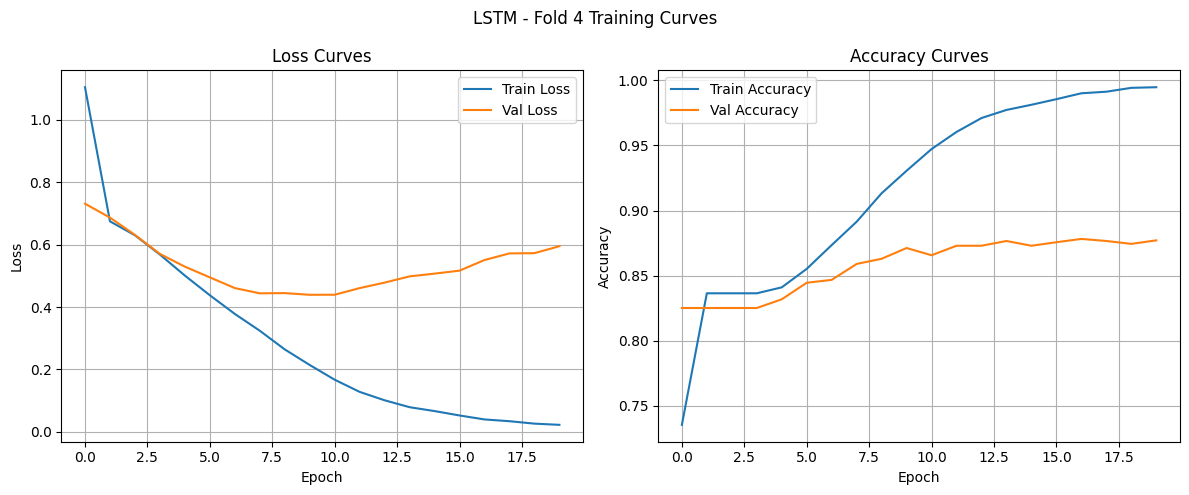

Fold 5/5
Training LSTM
Epoch 1/20, Train Loss: 1.0357, Train Acc: 0.7879, Val Loss: 0.7063, Val Acc: 0.8278
Epoch 2/20, Train Loss: 0.6716, Train Acc: 0.8358, Val Loss: 0.6610, Val Acc: 0.8278
Epoch 3/20, Train Loss: 0.6129, Train Acc: 0.8358, Val Loss: 0.6049, Val Acc: 0.8278
Epoch 4/20, Train Loss: 0.5439, Train Acc: 0.8366, Val Loss: 0.5564, Val Acc: 0.8306
Epoch 5/20, Train Loss: 0.4754, Train Acc: 0.8460, Val Loss: 0.5220, Val Acc: 0.8408
Epoch 6/20, Train Loss: 0.4092, Train Acc: 0.8641, Val Loss: 0.4957, Val Acc: 0.8502
Epoch 7/20, Train Loss: 0.3458, Train Acc: 0.8860, Val Loss: 0.4723, Val Acc: 0.8596
Epoch 8/20, Train Loss: 0.2838, Train Acc: 0.9080, Val Loss: 0.4594, Val Acc: 0.8599
Epoch 9/20, Train Loss: 0.2301, Train Acc: 0.9261, Val Loss: 0.4557, Val Acc: 0.8660
Epoch 10/20, Train Loss: 0.1827, Train Acc: 0.9412, Val Loss: 0.4703, Val Acc: 0.8621
Epoch 11/20, Train Loss: 0.1436, Train Acc: 0.9546, Val Loss: 0.4796, Val Acc: 0.8680
Epoch 12/20, Train Loss: 0.1109, Train A

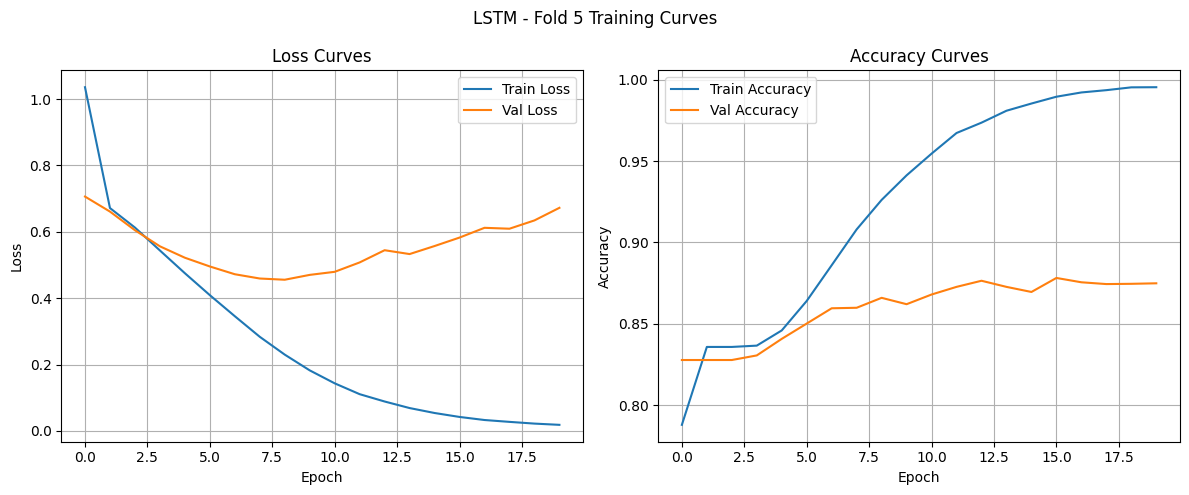

End of training


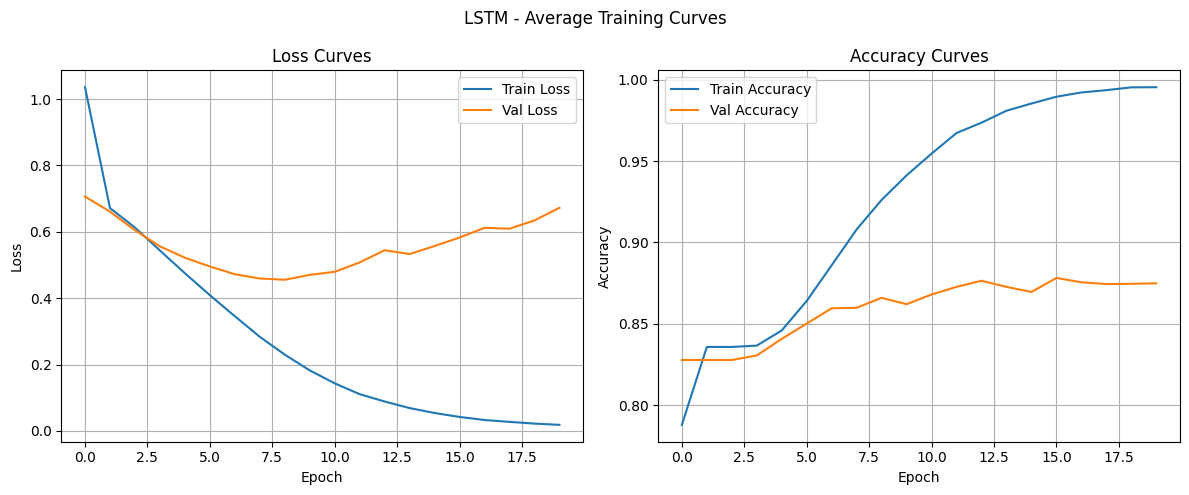


Best model from fold 2 with F1 score: 0.6087


In [32]:
lstm_model,lstm_metrics = train_model('LSTM', train_sentences, train_tags, word_index, tag_index, index_tag)

## Creating and training Transformer

Fold 1/5
Training Transformer
Epoch 1/20, Train Loss: 0.7610, Train Acc: 0.8186, Val Loss: 0.6175, Val Acc: 0.8516
Epoch 2/20, Train Loss: 0.6774, Train Acc: 0.8296, Val Loss: 0.5774, Val Acc: 0.8516
Epoch 3/20, Train Loss: 0.6328, Train Acc: 0.8298, Val Loss: 0.5609, Val Acc: 0.8516
Epoch 4/20, Train Loss: 0.5793, Train Acc: 0.8300, Val Loss: 0.5082, Val Acc: 0.8521
Epoch 5/20, Train Loss: 0.5114, Train Acc: 0.8384, Val Loss: 0.4842, Val Acc: 0.8563
Epoch 6/20, Train Loss: 0.4408, Train Acc: 0.8570, Val Loss: 0.4744, Val Acc: 0.8563
Epoch 7/20, Train Loss: 0.3902, Train Acc: 0.8743, Val Loss: 0.4977, Val Acc: 0.8347
Epoch 8/20, Train Loss: 0.3368, Train Acc: 0.8897, Val Loss: 0.4834, Val Acc: 0.8594
Epoch 9/20, Train Loss: 0.2724, Train Acc: 0.9125, Val Loss: 0.4979, Val Acc: 0.8614
Epoch 10/20, Train Loss: 0.2367, Train Acc: 0.9220, Val Loss: 0.5266, Val Acc: 0.8723
Epoch 11/20, Train Loss: 0.2027, Train Acc: 0.9338, Val Loss: 0.5362, Val Acc: 0.8740
Epoch 12/20, Train Loss: 0.1727, 

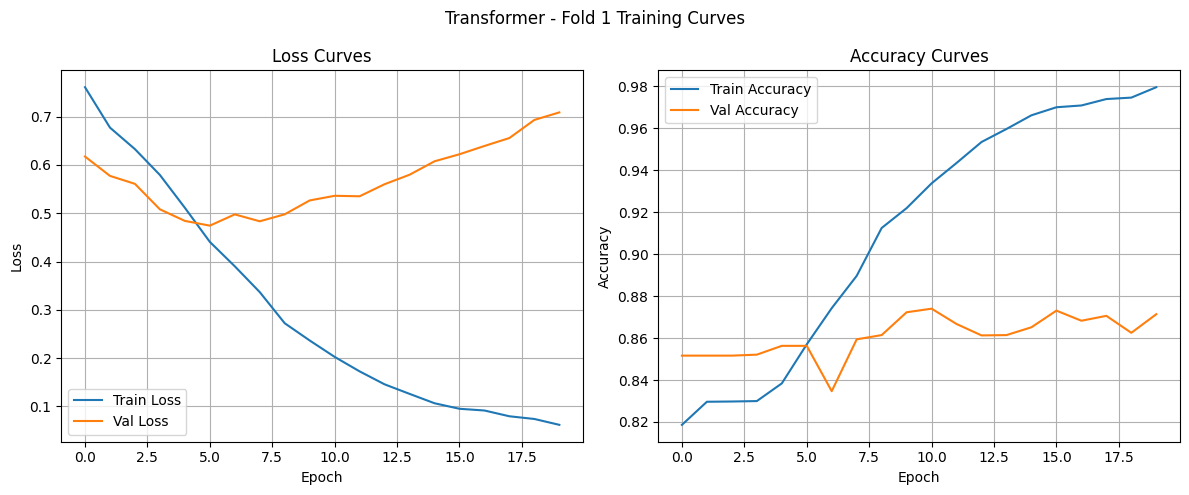

Fold 2/5
Training Transformer
Epoch 1/20, Train Loss: 0.7829, Train Acc: 0.8079, Val Loss: 0.6616, Val Acc: 0.8356
Epoch 2/20, Train Loss: 0.6748, Train Acc: 0.8338, Val Loss: 0.6258, Val Acc: 0.8356
Epoch 3/20, Train Loss: 0.6186, Train Acc: 0.8334, Val Loss: 0.5865, Val Acc: 0.8356
Epoch 4/20, Train Loss: 0.5619, Train Acc: 0.8338, Val Loss: 0.5610, Val Acc: 0.8379
Epoch 5/20, Train Loss: 0.5083, Train Acc: 0.8422, Val Loss: 0.5224, Val Acc: 0.8454
Epoch 6/20, Train Loss: 0.4433, Train Acc: 0.8572, Val Loss: 0.4930, Val Acc: 0.8490
Epoch 7/20, Train Loss: 0.3794, Train Acc: 0.8785, Val Loss: 0.4781, Val Acc: 0.8558
Epoch 8/20, Train Loss: 0.3163, Train Acc: 0.8988, Val Loss: 0.4951, Val Acc: 0.8551
Epoch 9/20, Train Loss: 0.2696, Train Acc: 0.9147, Val Loss: 0.4990, Val Acc: 0.8647
Epoch 10/20, Train Loss: 0.2276, Train Acc: 0.9248, Val Loss: 0.5001, Val Acc: 0.8678
Epoch 11/20, Train Loss: 0.1978, Train Acc: 0.9365, Val Loss: 0.5341, Val Acc: 0.8599
Epoch 12/20, Train Loss: 0.1685, 

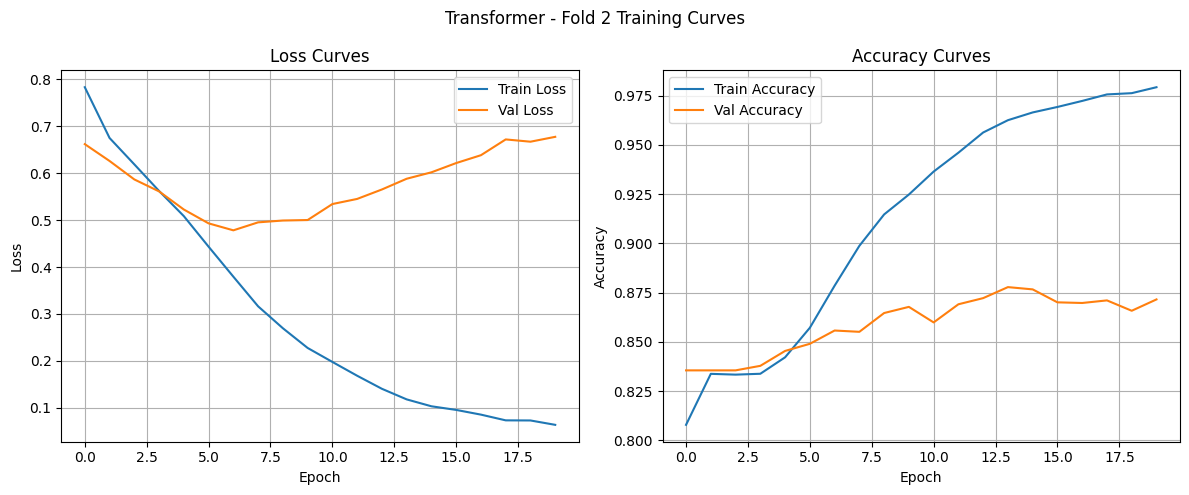

Fold 3/5
Training Transformer
Epoch 1/20, Train Loss: 0.7691, Train Acc: 0.8132, Val Loss: 0.6929, Val Acc: 0.8303
Epoch 2/20, Train Loss: 0.6581, Train Acc: 0.8351, Val Loss: 0.6361, Val Acc: 0.8303
Epoch 3/20, Train Loss: 0.6156, Train Acc: 0.8347, Val Loss: 0.5959, Val Acc: 0.8302
Epoch 4/20, Train Loss: 0.5592, Train Acc: 0.8360, Val Loss: 0.5657, Val Acc: 0.8338
Epoch 5/20, Train Loss: 0.5005, Train Acc: 0.8438, Val Loss: 0.5417, Val Acc: 0.8368
Epoch 6/20, Train Loss: 0.4481, Train Acc: 0.8558, Val Loss: 0.5374, Val Acc: 0.8416
Epoch 7/20, Train Loss: 0.3889, Train Acc: 0.8731, Val Loss: 0.4935, Val Acc: 0.8479
Epoch 8/20, Train Loss: 0.3368, Train Acc: 0.8892, Val Loss: 0.5215, Val Acc: 0.8562
Epoch 9/20, Train Loss: 0.2923, Train Acc: 0.9045, Val Loss: 0.5262, Val Acc: 0.8553
Epoch 10/20, Train Loss: 0.2422, Train Acc: 0.9181, Val Loss: 0.5318, Val Acc: 0.8572
Epoch 11/20, Train Loss: 0.2084, Train Acc: 0.9320, Val Loss: 0.5450, Val Acc: 0.8560
Epoch 12/20, Train Loss: 0.1717, 

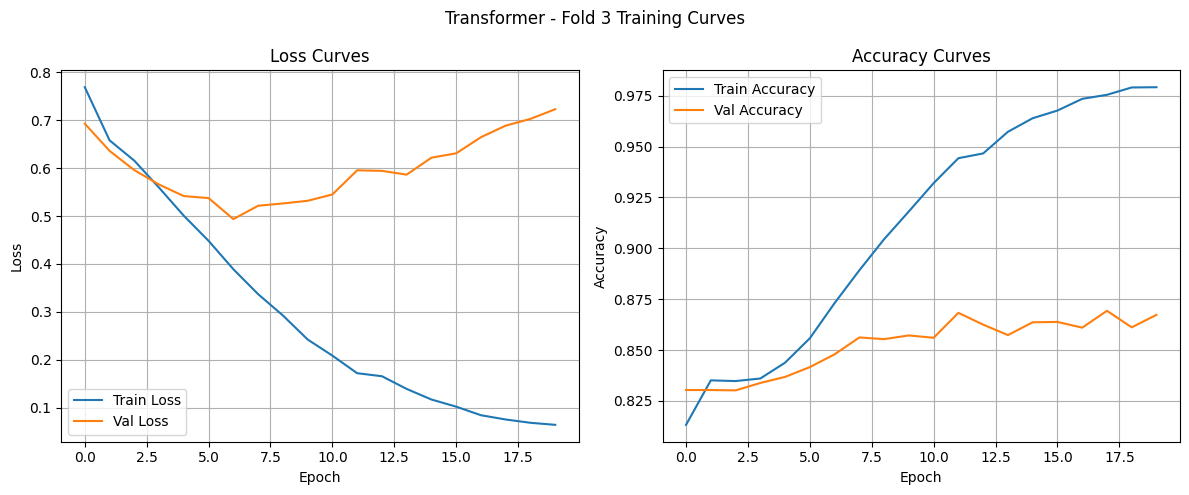

Fold 4/5
Training Transformer
Epoch 1/20, Train Loss: 0.7458, Train Acc: 0.8189, Val Loss: 0.7030, Val Acc: 0.8252
Epoch 2/20, Train Loss: 0.6596, Train Acc: 0.8364, Val Loss: 0.6557, Val Acc: 0.8252
Epoch 3/20, Train Loss: 0.6112, Train Acc: 0.8364, Val Loss: 0.6157, Val Acc: 0.8269
Epoch 4/20, Train Loss: 0.5474, Train Acc: 0.8392, Val Loss: 0.5672, Val Acc: 0.8337
Epoch 5/20, Train Loss: 0.4813, Train Acc: 0.8524, Val Loss: 0.5519, Val Acc: 0.8418
Epoch 6/20, Train Loss: 0.4164, Train Acc: 0.8679, Val Loss: 0.5072, Val Acc: 0.8520
Epoch 7/20, Train Loss: 0.3518, Train Acc: 0.8866, Val Loss: 0.5157, Val Acc: 0.8539
Epoch 8/20, Train Loss: 0.2973, Train Acc: 0.9045, Val Loss: 0.5172, Val Acc: 0.8599
Epoch 9/20, Train Loss: 0.2495, Train Acc: 0.9198, Val Loss: 0.5208, Val Acc: 0.8580
Epoch 10/20, Train Loss: 0.2233, Train Acc: 0.9262, Val Loss: 0.5428, Val Acc: 0.8601
Epoch 11/20, Train Loss: 0.1827, Train Acc: 0.9416, Val Loss: 0.5532, Val Acc: 0.8596
Epoch 12/20, Train Loss: 0.1519, 

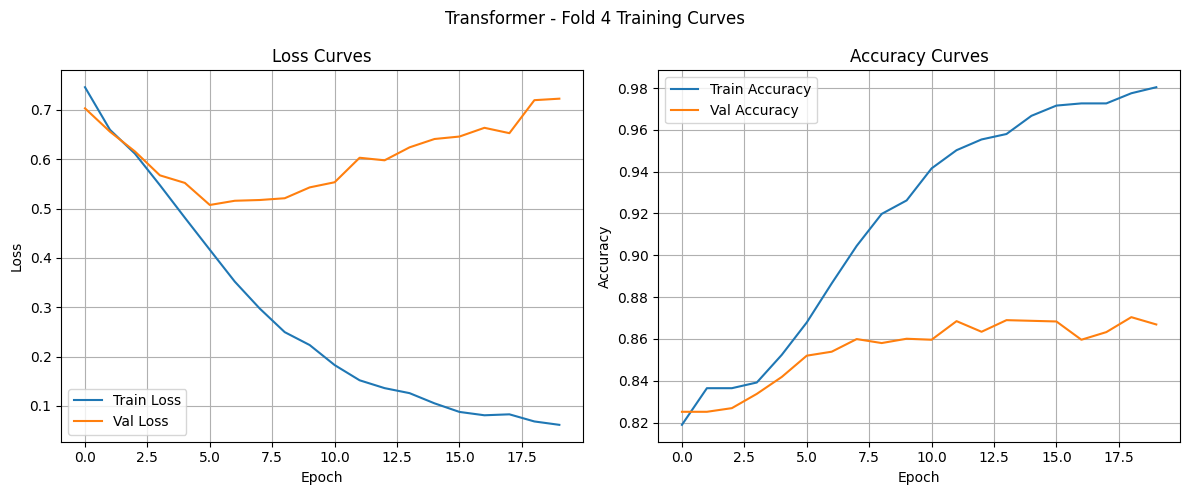

Fold 5/5
Training Transformer
Epoch 1/20, Train Loss: 0.7460, Train Acc: 0.8193, Val Loss: 0.6854, Val Acc: 0.8278
Epoch 2/20, Train Loss: 0.6529, Train Acc: 0.8358, Val Loss: 0.6422, Val Acc: 0.8278
Epoch 3/20, Train Loss: 0.6002, Train Acc: 0.8357, Val Loss: 0.6149, Val Acc: 0.8286
Epoch 4/20, Train Loss: 0.5455, Train Acc: 0.8387, Val Loss: 0.5800, Val Acc: 0.8303
Epoch 5/20, Train Loss: 0.4843, Train Acc: 0.8485, Val Loss: 0.5526, Val Acc: 0.8369
Epoch 6/20, Train Loss: 0.4252, Train Acc: 0.8652, Val Loss: 0.5661, Val Acc: 0.8334
Epoch 7/20, Train Loss: 0.3598, Train Acc: 0.8849, Val Loss: 0.5515, Val Acc: 0.8475
Epoch 8/20, Train Loss: 0.3048, Train Acc: 0.9022, Val Loss: 0.5374, Val Acc: 0.8519
Epoch 9/20, Train Loss: 0.2548, Train Acc: 0.9189, Val Loss: 0.5471, Val Acc: 0.8550
Epoch 10/20, Train Loss: 0.2114, Train Acc: 0.9319, Val Loss: 0.5595, Val Acc: 0.8545
Epoch 11/20, Train Loss: 0.1810, Train Acc: 0.9425, Val Loss: 0.5871, Val Acc: 0.8574
Epoch 12/20, Train Loss: 0.1469, 

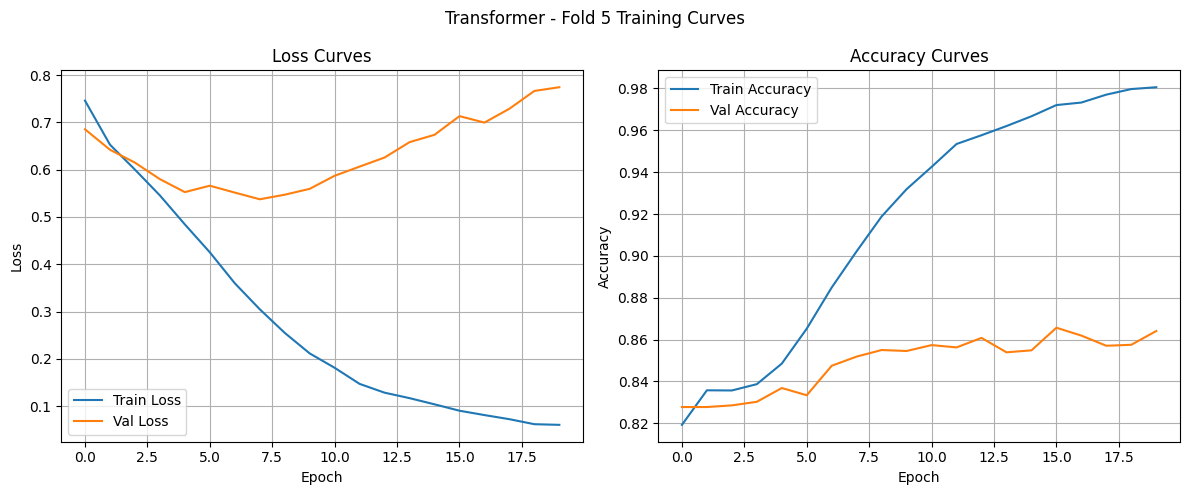

End of training


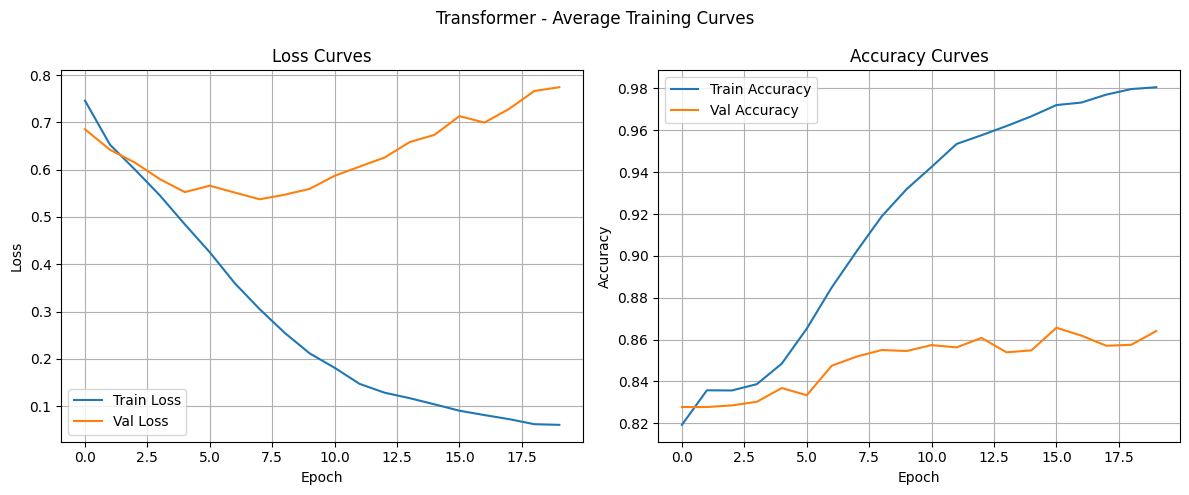


Best model from fold 4 with F1 score: 0.5760


In [33]:
transformer_model,transformer_metrics = train_model('transformer', train_sentences, train_tags, word_index, tag_index, index_tag)

### F1 Score of both LSTM and Transformers

In [34]:
lstm_f1 = lstm_metrics['bestF1']
transformer_f1 = transformer_metrics['bestF1']

print(f"LSTM best F1: {lstm_f1:.4f}")
print(f"Transformer best F1: {transformer_f1:.4f}")

LSTM best F1: 0.6087
Transformer best F1: 0.5760


---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


In [35]:
if lstm_f1 > transformer_f1:
  best_model = lstm_model
  best_mname ='LSTM'
else:
  best_model = transformer_model
  best_mname ='Transformer'

print(f"Best model is {best_mname} with F1 score of {max(lstm_f1,transformer_f1):.4f}")

Best model is LSTM with F1 score of 0.6087


In [36]:
def plot_conf_mtx(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    Plot confusion matrix for the NER model
    Args:
    y_true (list) -> list of true labels
    y_pred (list) -> list of predicted labels
    classes (list) -> list of class names
    normalize (bool) -> whether to normalize confusion matrix
    title (str) -> title of the plot
    cmap -> colormap for the plot
    figsize (tuple) -> figure size

    Returns:
    fig -> matplotlib figure object
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        if title is None:
            title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        if title is None:
            title = 'Confusion Matrix'

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return fig

In [37]:
def evaluate_model(model, sentences, tags,word_index, tag_index, index_tag):
    """
    Function to Evaluate final model on test data
    Args:
    model (Custom Class) -> either LSTM or Transformer
    sentences (list) -> list of sentences
    tags (list) -> list of tags
    word_index (dict) -> dictionary of words
    tag_index (dict) -> dictionary of tags
    index_tag (dict) -> dictionary of tags with index as keys

    Returns:
    test_metrics (dict) -> dictionary of metrics
    """
    test_data = data_loader(sentences, tags, word_index, tag_index, index_tag)
    criterion = nn.CrossEntropyLoss(reduction='none')

    test_metrics = evaluate(model, test_data, criterion, device, index_tag)
    print("Evaluation Results")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    if 'f1' in test_metrics:
      print(f"Test F1: {test_metrics['f1']:.4f}")
      print(f"Test Precision: {test_metrics['precision']:.4f}")
      print(f"Test Recall: {test_metrics['recall']:.4f}")

    if 'report' in test_metrics:
      print("\nDetailed Classification Report:")
      print(test_metrics['report'])

    if 'filtered_labels' in test_metrics and 'filtered_predictions' in test_metrics:
      plt.figure(figsize=(12, 10))
      unique_tags = test_metrics['unique_tags']

      confmatx_fig = plot_conf_mtx(
            test_metrics['filtered_labels'],
            test_metrics['filtered_predictions'],
            classes=unique_tags,
            title='Confusion Matrix'
        )
      plt.savefig('confusion_matrix.png')

      n_confmtx_fig = plot_conf_mtx(
            test_metrics['filtered_labels'],
            test_metrics['filtered_predictions'],
            classes=unique_tags,
            normalize=True,
            title='Normalized Confusion Matrix'
        )
      plt.savefig('normalized_confusion_matrix.png')
      plt.show()

    return test_metrics


## Evaluating best model on Test Data

Vocabulary size: 2882
Tag classes: 5
Tags: ['I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
Evaluation Results
Test Loss: 1.9405
Test Accuracy: 0.7293
Test F1: 0.2131
Test Precision: 0.2123
Test Recall: 0.2152

Detailed Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.05      0.06      0.06       278
       I-LOC       0.03      0.03      0.03       267
      I-MISC       0.03      0.02      0.02       381
       I-ORG       0.10      0.11      0.10       326
       I-PER       0.85      0.86      0.85      6525

    accuracy                           0.73      7777
   macro avg       0.21      0.22      0.21      7777
weighted avg       0.72      0.73      0.72      7777



<Figure size 1200x1000 with 0 Axes>

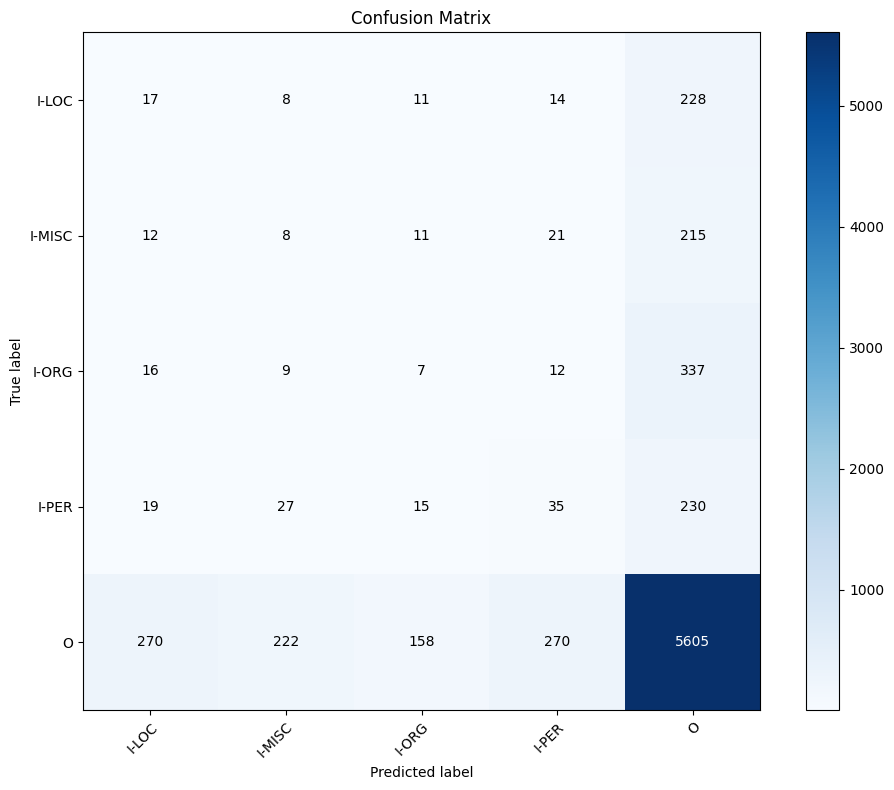

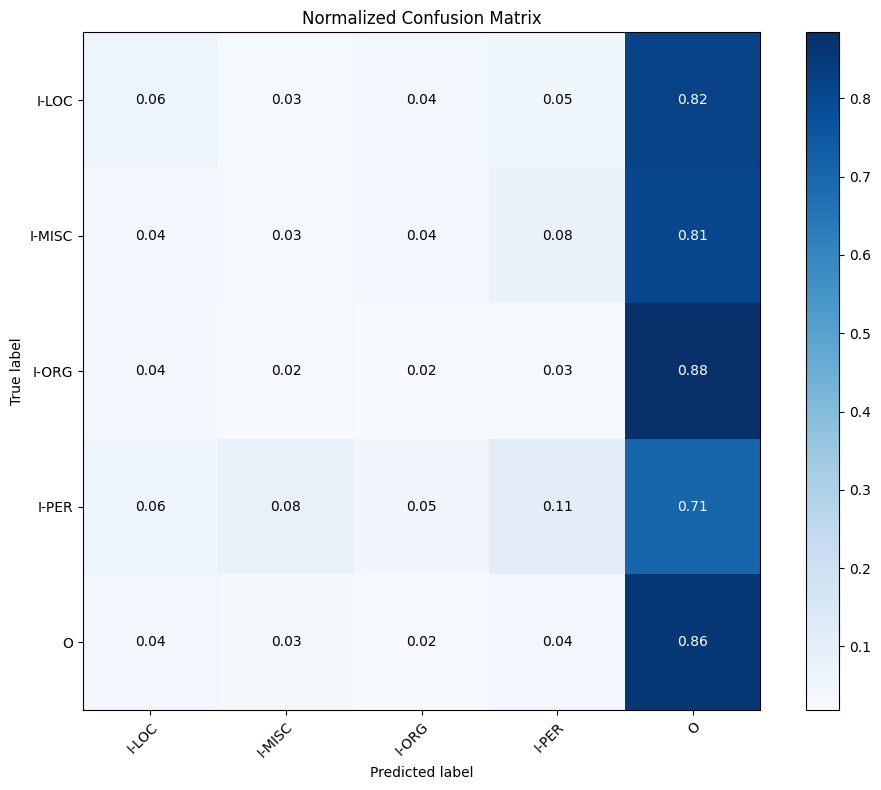

In [38]:
test_word_index,test_tag_index,test_index_tag = word_tag_counter(test_sentences, test_tags)
test_metrics = evaluate_model(best_model, test_sentences, test_tags, test_word_index,test_tag_index,test_index_tag)